In [1]:
%pylab
%matplotlib inline 
from mnist import load_mnist
train_data, train_labels = load_mnist(dataset='training', path='./')
test_data, test_labels = load_mnist(dataset='testing', path='./')

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np

train_data = np.reshape(train_data, (60000, 28 * 28)).T
test_data  = np.reshape(test_data,  (10000, 28 * 28)).T

In [3]:
(train_data.shape, train_labels.shape)

((784, 60000), (60000,))

In [4]:
TRAINBIN=np.where(train_data < 0.5, 0, 1);
TESTBIN=np.where(test_data < 0.5, 0, 1);

# Partie 1 : Théorie


Soit $K$ le nombre de distribution de Bernouilli.<br />
Soit $D$ le nombre de variables.<br />
Soit $N$ le nombre de données.<br />
Soit $X$ une matrice de taille $D*N$ contenant nos données d'apprentissage.<br />
Soit $\mu$ une matrice de taille $D*K$ contenant les moyennes de chaque distribution de Bernouilli.<br />
Soit $\Pi$ un vecteur de taille $K$ contenant le poid de chaque distribution.<br />

### Etape E:
L'tape E revient à calculer les probabilités des composante, sachant le dataset. Cette probabilité sera ensuite utilisé pour éstimer les nouveaux parametres qui maximise la vraiessemblance. En utilisant la formule de Bayes, on obtient:

$$P(\mu^{(k)}, \Pi^{(k)} | X^{(j)}) = 
\frac{P(X^{(j)}|\mu^{(k)})\Pi^{(k)}}{\sum_{k=1}^K{ P(X^{(j)}|\mu^{(k)})\Pi^{(k)}}}$$

S'il y a K composantes et N images, il faut donc calculer $N * K$ probabilité 
En supposant que les images suivent une loi de bernouilli, on a:
$$P(X^{(j)}|\mu^{(k)}) = \prod_{i=1}^{D}{(\mu^{(k)}_{i})^{X^{(j)}_{i}}(1 - \mu^{(k)}_{i})^{(1 - X^{(j)}_{i})}}$$

En passant au log, on obtient:

$$log P(X^{(j)}|\mu^{(k)}) = {\sum_{i=1}^D{{X^{(j)}_{i}}log({\mu^{(k)}_{i}}) + {(1 - X^{(j)}_{i})}log(1 - \mu^{(k)}_{i})}}$$

### Etape M

L'etape M revient à calculer les parametres qui maximisent le log de vraisemblance. Dans une distribution de Bernouilli, on obtient après calcule:

$$\Pi^{(k)} = \frac{\sum_{j=1}^N P(\mu^{(k)}, \Pi^{(k)} | X^{(j)})}{N}$$

$$\mu^{(k)}_{i} = \frac{\sum_{j=1}^N P(\mu^{(k)}, \Pi^{(k)} | X^{(j)}) X^{(j)}_{i}}{\sum_{j=1}^N P(\mu^{(k)}, \Pi^{(k)} | X^{(j)})}$$



# Partie 2 : Implémentation

Dans cette partie on implemente la classe EM qui apprend à maximiser le log de vraisemblance

Il faut faire attention à la manipulation des valeurs de probabilités (entre 0 et 1\) qui deviennent rapidement nulles à cause de la précision des chiffres flottants

In [14]:
from numpy import matlib 

class EM:
    
    def __expectation(self, with_sigma):
        """Computes log of P(parameters| Xi) for all Xi in the data set X
            Expectation step of the EM 
            
            :param with_sigma: a boolean indicating whether to use sigma when computing the probability.    
            :rtype: numpy array of size (K, N)
        """
        
        w = np.copy(self.weights)
        w[w == 0] = 1e-10
        ln_weights = np.log(w)
        ln_probk = np.empty((self.K, self.N))
        for k in range(self.K): 
            if not with_sigma:
                p = self.proba_log_func(self.data, self.means[:, k]) 
            else:
                p = self.proba_log_func(self.data, self.means[:, k], self.sigmas[:, :, k])
            ln_probk[k, :] = p + ln_weights[k]
        prob = np.sum(np.exp(ln_probk), axis = 0)
        prob[prob == 0] = 1e-10
        self.log_likelihood = np.sum(np.log(prob)) # saving log-likelihood
        ln_probk -= np.log(prob) # num/denum <=> log(num) - log(denum)
        return ln_probk
        
    def __maximization(self, ln_prob, with_sigma):
        """Computes the new parameters that maximizes the log-likelihood 
            Maximization step of the EM
            
            :param ln_prob: the numpy array returned by __expectation
            :param with_sigma: a boolean indicating whether to use sigma when computing the new parameters.
            :rtype: 3 numpy arrays: numpy array of size (K), 
                                    numpy array of size (D, K),
                                    numpy array of size (D, D, K) 
        """
        
        prob = np.exp(ln_prob)
        Nk = np.sum(prob, axis = 1)
        weights = Nk / self.N
        Nk[Nk == 0] = 1e-10
        means = np.empty((self.D, self.K))
        if with_sigma:
            sigmas = np.empty((self.D, self.D, self.K))
        for k in range(self.K):
            means[:, k] = self.maximizing_mean_func(prob[k, :], self.data)
            if with_sigma:
                sigma = self.maximizing_sigma_func(prob[k, :], self.data, self.means[:, k]) / Nk[k]
                while np.linalg.det(sigma) == 0:
                    sigma = self.__floor_sigma(sigma)
                sigmas[:, :, k] = sigma
        if with_sigma:
            return weights, means / Nk, sigmas
        return weights, means / Nk, None     
    
    def __floor_sigma(self, sigma, rep = False):
        """Computes the new sigma floored to 1
            
            :param sigma: sigma to be floored  
            :rtype: numpy array of size (D, D)
        """
        
        if rep:
            floor = self.floor * 2
            L = np.linalg.cholesky(floor)
            L_inv = np.linalg.inv(L)
        else:
            L = self.L
            L_inv = self.L_inv
        T = L_inv @ sigma @ L_inv.T
        eig_values, eig_vectors = np.linalg.eigh(T)
        D = np.diag(eig_values)
        D[D < 1] = 1
        T = eig_vectors @ D @ np.linalg.inv(eig_vectors) 
        return L @ T @ L.T
    
    def __init_floor(self):
        """Initialise the floor of sigma.
            
            :rtype: None
        """
        
        cov = np.cov(self.data)
        self.floor = cov * 0.2
        self.L = np.linalg.cholesky(self.floor)
        self.L_inv = np.linalg.inv(self.L)
        
            
    def set_em_functions(self, proba_log_func, maximizing_mean_func, maximizing_sigma_func = None):
        """Sets the functions to be used while training the EM
            
            :param proba_log_func: the function which computes the log of a probability
            :param maximizing_mean_func: the function which computes the mean maximizing the log-likelihood
            :param maximizing_sigma_func: the function which computes the sigma maximizing the log-likelihood
            :rtype: None
        """
        
        self.proba_log_func = proba_log_func
        self.maximizing_mean_func = maximizing_mean_func
        self.maximizing_sigma_func = maximizing_sigma_func
    
    def init_parameters(self, data, K, weights = None, means = None, sigmas = None):
        """Initialise the parameters to be used in the EM.
            If parameters are not specified, they are computed in the class using:
                __init_weights, __init_means and __init_sigmas
            
            :param data: an numpy array containing the training set.
            :param K: an int containing the number of components in the mixture model
            :param weights: an numpy array containing the initial weight of each component.
            :param means: an numpy array containing the initial mean of each component.
            :param sigmas: an numpy array containing the initial sigma of each component.
            :rtype: None
        """
        
        self.log_likelihood = -float('Inf')
        self.data = data
        self.K = K
        self.D = data.shape[0]
        self.N = data.shape[1]
        self.weights = weights
        self.means = means
        self.sigmas = sigmas
        if weights is None:
            self.__init_weights()
        if means is None:
            means = self.__init_means()
        if self.maximizing_sigma_func is not None:
            if sigmas is None:
                sigmas = self.__init_sigmas()
            self.__init_floor() 
        
    def __init_weights(self):
        """Initialise the weight of each component.
        
            :rtype: None
        """
        
        self.weights = np.ones(self.K) / self.K
        
    def __init_means(self):
        """Initialise the mean of each component.
            Uses LBG to initialise means
            :rtype: None
        """
        
        mean = np.mean(self.data, axis = 1)
        self.means = np.empty((self.D, self.K))
        e = 0.1
        for k in range(self.K):
            for d in range(self.D):
                if random.random() > 0.5:
                    self.means[d, k] = min(mean[d] + e, 1)
                else:
                    self.means[d, k] = max(mean[d] - e, 0)
                    
    def __init_sigmas(self):
        """Initialise the sigma of each component.
        
            :rtype: None
        """
        
        self.sigmas = np.empty((self.D, self.D, self.K))
        for k in range(K):
            self.sigmas[:, :, k] = np.eye((self.D))
    
    def train(self, with_sigma = False, eps = 1000): 
        """Train the EM and returns the parameters which maximizes the log-likelihood.
            
            :param with_sigma: a boolean indicating whether to use sigma in EM.
            :param eps: an int representing the log-likelihood threshold
            :rtype: 2 or 3 numpy arrays depending on the value of with_sigma
                 with_sigma = False: numpy array of size (K), numpy array of size (D, K),
                 with_sigma = True: adds an numpy array of size (D, D, K) to the return value.
        """
        
        diff = float('Inf')
        i = 0
        while (diff > eps) :
            last_log_likelihood = self.log_likelihood
            ln_prob = self.__expectation(with_sigma)
            new_weights, new_means, new_sigmas = self.__maximization(ln_prob, with_sigma)
            diff = np.abs(last_log_likelihood - self.log_likelihood)
            self.means = new_means
            self.weights = new_weights
            self.sigmas = new_sigmas
        if with_sigma:
            return self.weights, self.means, self.sigmas
        return self.weights, self.means

In [6]:
def bernouilli(X, Mu):
    """Computes log of P(X | Mu) for all Xi in the data set X using Bernouilli distribution
            
            :param X: numpy array containg the data set with rows as features
            :param Mu: numpy array containg the estimated mean of the dataset X
            :rtype: numpy array of size (N)
    """
    
    N = X.shape[1]
    M = np.matlib.repmat(Mu, N, 1).T
    P = M * X + (1 - M) * (1 - X)
    P[P == 0] = 1 # to avoid log(0) and not take care of this value cz log(1) = 0
    return np.sum(np.log(P), axis = 0)

def bernouilli_means(P, X):
    """Computes the mean maximizing the log-likelihood of the data set X using Bernouilli distribution
            
            :param P: numpy array containg P(X | parameters)
            :param X: numpy array containg the data set with rows as features
            :rtype: numpy array of size (D)
    """
    
    D = X.shape[0]
    p = np.matlib.repmat(P, D, 1)
    return np.sum(p * X, axis = 1)

def train_bernouilli(K):
    """Launches the EM on each class of the TRAINBIN with K components using Bernouilli distribution.
            
            :param K: an int containg the number of components in each class.
            :rtype: numpy array of size (K), numpy array of size (D, K)
    """
    
    nb_class = 10
    weights = [None] * nb_class
    means = [None] * nb_class
    em = EM()
    em.set_em_functions(bernouilli, bernouilli_means)
    for i in range(nb_class):
        data = TRAINBIN[:, np.where(train_labels == i)[0]]
        em.init_parameters(data, K)
        w, m = em.train()
        weights[i] = w
        means[i] = m
    return np.array(weights), np.array(means)

In [7]:
K = 1
weights, means = train_bernouilli(K)

2) Afficher les moyennes des différentes distributions de Bernoulli.

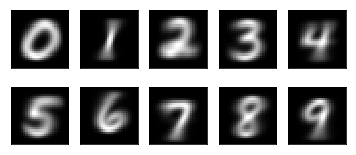

In [8]:
import visualize as vz
tmp = means.T
vz.plotGroupImages(tmp[0])

Une fois entrainé, on peut alors tester un classifieur bayésien en utilisant un mélange pour chaque classe. On testera le classifieur avec 1, 2, 4 et 8 composantes par classe.

In [6]:
def bayes_class(data, K, weights, means, proba_log_func, sigmas = None):
    """Naive Bayes Classifier of the data set data
            
            :param data: numpy array containg the data set with rows as features
            :param K: int containg the number of components in the dataset X
            :param weights: numpy array containg the weight of each component in the dataset X
            :param means: numpy array containg the mean of each component in the dataset X
            :param proba_log_func: the function which computes the log of a probability
            :param sigmas: numpy array containg the sigma of each component in the dataset X
            :rtype: numpy array of size (N)
    """
    D = data.shape[0]
    N = data.shape[1]
    nb_class = 10
    prob = np.zeros((nb_class, N))
    ln_weights = np.log(weights)
    for c in range(nb_class):
        ln_p = np.empty((K, N))
        for k in range(K):
            if sigmas is None:
                ln_p[k, :] = proba_log_func(data, means[c, :, k]) + ln_weights[c, k]    
            else:
                ln_p[k, :] = proba_log_func(data, means[c, :, k], sigmas[c, :, :, k]) + ln_weights[c, k] 
        p = np.sum(np.exp(ln_p), axis = 0)
        prob[c, :] = p
    return np.argmax(prob, axis = 0)

### Test sur 1, 2, 4 et 8 composantes par classes

In [10]:
weights = {}
means = {}
out = {}
for K in [1, 2, 4, 8]:
    w, m = train_bernouilli(K)
    t_data = TESTBIN
    o = bayes_class(test_data, K, w, m, bernouilli)
    print("K: " ,K , ", Precision: " ,(o == test_labels).sum() / test_labels.shape[0])
    weights[str(K)] = w
    means[str(K)] = m
    out[str(K)] = o

K:  1 , Precision:  0.8132
K:  2 , Precision:  0.8548
K:  4 , Precision:  0.8896
K:  8 , Precision:  0.9152


# Partie 3 : Comparaison avec un GMM

Dans cette partie, on va comparer les résultats obtenus avec le cas d’un mélange de gaussiennes sur les données brutes TRAIN et TEST avec un mélange de bernouilli.

* On commencera par le cas de gaussienne avec des matrices de covariance diagonale, ensuite tester la version avec matrices de covariance complète.
* On fera attention à la dégénérescence de l’algorithme EM (matrice de covariance non inversible). Il faut voir comment gérer ce problème ainsi que l’initialisation.

In [7]:
from numpy import linalg as LA

class PCA:
    
    def __compute_eig(self, data):
        cov = np.cov(data)
        self.means = np.mean(data, axis = 1)
        eig_values, eig_vectors = LA.eig(cov)
        if eig_values.imag.sum() != 0:
            print("Error: covariance of data is not symetrique. \
            It has some complex eigen values.")
        idx = eig_values.argsort()[::-1] 
        self.eig_values = eig_values[idx].real
        self.eig_vectors= eig_vectors[:,idx].real

    def __project(self, data, n = -1):
        if n == -1:
            n = self.get_vectorsNb(0.5)
        centeredData = data - np.matlib.repmat(self.means, data.shape[1], 1).T
        return self.eig_vectors[:, :n].T @ (centeredData)
    
    
    
    def get_vectorsNb(self, error_percent):
        if error_percent < 0 or error_percent > 100:
            print("error_percent should be between 0 and 100")
            return -1
        info_percent = (100 - error_percent) / 100.0
        eigSum = np.sum(self.eig_values)
        for i in range(self.eig_values.shape[0]):
            if np.sum(self.eig_values[:i]) / eigSum >= info_percent :
                return i
        return -1
    
    def extract_features(self, train_data, test_data, n = 50):
        if n == 0:
            return train_data, test_data
        self.__compute_eig(train_data)
        return pca.__project(train_data, n), pca.__project(test_data, n)
    
    def reproject_features(self, features, n = 50):
        N = features.shape[1]
        return self.eig_vectors[:, :n] @ features + np.matlib.repmat(self.means, N, 1).T

In [25]:
# il faut faire une projection pca pour rendre la matrice de variance inversible
pca = PCA()
train, test = pca.extract_features(train_data, test_data)

In [15]:
def normal(X, Mu, Sigma):
    """Computes log of P(X | Mu, Sigma) for all Xi in the data set X using Normal distribution
            
            :param X: numpy array containg the data set with rows as features
            :param Mu: numpy array containg the estimated sigma of the dataset X
            :param Mu: numpy array containg the estimated mean of the dataset X
            :rtype: numpy array of size (N)
    """
    
    D = X.shape[0]
    N = X.shape[1]
    det = np.linalg.det(Sigma)
    sigma_inv = np.linalg.inv(Sigma)
    P = np.full((N), np.log(det) + D * np.log(2 * math.pi))
    for i in range(N):
        P[i] +=  (X[:, i] - Mu).T @ sigma_inv @ (X[:, i] - Mu)
    P *= -0.5 
    return P

def normal_means(P, X):
    """Computes the mean maximizing the log-likelihood of the data set X using Normal distribution
            
            :param P: numpy array containg P(X | parameters)
            :param X: numpy array containg the data set with rows as features
            :rtype: numpy array of size (D)
    """
    
    D = X.shape[0]
    p = np.matlib.repmat(P, D, 1)
    return np.sum(p * X, axis = 1)

def normal_sigmas(P, X, Mu):
    """Computes the full covariance matrix maximizing the log-likelihood of the data set X using Normal distribution
            
            :param P: numpy array containg P(X | parameters)
            :param X: numpy array containg the data set with rows as features
            :param Mu: numpy array containg the estimated mean of the dataset X
            :rtype: numpy array of size (D, D)
    """
    
    D = X.shape[0]
    N = X.shape[1]
    sigma = np.zeros((D, D))
    for i in range(N):
        m = (X[:, i] - Mu).reshape(D, 1)
        s = m @ m.T
        sigma += P[i] * s
    return sigma
   
def normal_diag_sigmas(P, X, Mu):
    """Computes the diagonal covariance matrix maximizing the log-likelihood of the data set X 
       using Normal distribution
            
            :param P: numpy array containg P(X | parameters)
            :param X: numpy array containg the data set with rows as features
            :param Mu: numpy array containg the estimated mean of the dataset X
            :rtype: numpy array of size (D, D)
    """
    
    cov = normal_sigmas(P, X, Mu)
    return np.diag(cov.diagonal())

def train_gauss_diag(train_data, K):
    """Launches the EM on each class of the train_data with K components 
       using Normal distribution with diagonal covariance matrix. (Independant components)
            
            :param train_data: numpy array containg the data set with rows as features
            :param K: an int containg the number of components in each class.
            :rtype: numpy array of size (K), numpy array of size (D, K), numpy array of size (D, D, K)
    """
    
    nb_class = 10
    weights = [None] * nb_class
    means = [None] * nb_class
    sigmas = [None] * nb_class
    em = EM()
    em.set_em_functions(normal, normal_means, normal_diag_sigmas)
    for i in range(nb_class):
        data = train_data[:, np.where(train_labels == i)[0]] 
        em.init_parameters(data, K)
        w, m, s = em.train(with_sigma = True)
        weights[i] = w
        means[i] = m
        sigmas[i] = s
    return np.array(weights), np.array(means), np.array(sigmas)

### Avec une matrice de variance-covariance diagonale

In [15]:
weights = {}
means = {}
sigmas = {}
out = {}
train, test = extract_features(train_data, test_data)
for K in [1, 2, 4, 8]:
    w, m, s = train_gauss_diag(train, K)
    o = bayes_class(test, K, w, m, normal, s)
    print("K: " ,K , ", Precision: " ,(o == test_labels).sum() / test_labels.shape[0])
    weights[str(K)] = w
    means[str(K)] = m
    sigmas[str(K)] = s
    out[str(K)] = o

K:  1 , Precision:  0.8781
K:  2 , Precision:  0.8874
K:  4 , Precision:  0.908
K:  8 , Precision:  0.9203


### Avec une matrice de variance-covariance complete

In [10]:
def train_gauss(train_data, K):
    """Launches the EM on each class of the train_data with K components 
       using Normal distribution with full covariance matrix. (corrolated components)
            
            :param train_data: numpy array containg the data set with rows as features
            :param K: an int containg the number of components in each class.
            :rtype: numpy array of size (K), numpy array of size (D, K), numpy array of size (D, D, K)
    """
    
    nb_class = 10
    weights = [None] * nb_class
    means = [None] * nb_class
    sigmas = [None] * nb_class
    em = EM()
    em.set_em_functions(normal, normal_means, normal_sigmas)
    for i in range(nb_class):
        data = train_data[:, np.where(train_labels == i)[0]] 
        em.init_parameters(data, K)
        w, m, s = em.train(with_sigma = True)
        weights[i] = w
        means[i] = m
        sigmas[i] = s
    return np.array(weights), np.array(means), np.array(sigmas)

In [66]:
weights = {}
means = {}
sigmas = {}
out = {}
for K in [1, 2, 4, 8]:
    w, m, s = train_gauss(train, K)
    o = bayes_class(test, K, w, m, normal, s)
    print("K: " ,K , ", Precision: " ,(o == test_labels).sum() / test_labels.shape[0])
    weights[str(K)] = w
    means[str(K)] = m
    sigmas[str(K)] = s
    out[str(K)] = o

K:  1 , Precision:  0.9637
K:  2 , Precision:  0.9642
K:  4 , Precision:  0.9701
K:  8 , Precision:  0.9767


On remarque facilement que le passage au GMM avec des matrices de variance covariance complète donne une meilleur classification que toutes les autres methodes qu'on a essayé dans ce tp, surtout quand on augmente K. Pour avoir une meuilleur performence, il suffit d'entrener le modèle avec un nombre plus grand de composante par classe.